In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [4]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [5]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [49.79, 53.45]


/home/phomint/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


In [6]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [7]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [8]:
def imprime_resultados(results):
    media = results['test_score'].mean() * 100
    desvio = results['test_score'].std() * 100
    print("Accuracy médio %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [9]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


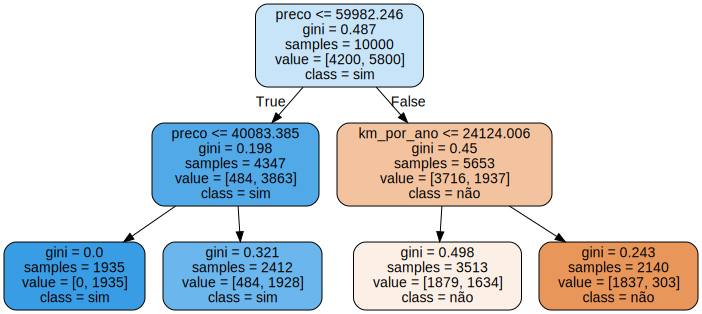

In [10]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
modelo.fit(x_azar, y_azar)
dot_data=export_graphviz(modelo, filled=True, rounded=True,
                class_names=['não', 'sim'], feature_names= features)
graph = graphviz.Source(dot_data)
graph

In [11]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [12]:
def decision_tree_run(max_depth):
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)   
    return [results['train_score'].mean(), results['test_score'].mean(), max_depth]

In [13]:
resultados = pd.DataFrame([decision_tree_run(i) for i in range(1, 32)], columns=['train', 'test', 'max_depth'])

In [14]:

resultados

,train,test,max_depth
0,0.757912,0.757842,1
1,0.757912,0.757842,2
2,0.787510,0.786726,3
3,0.787876,0.786227,4
4,0.789410,0.785458,5
5,0.791701,0.781233,6
6,0.794957,0.779632,7
7,0.798867,0.778389,8
8,0.804668,0.773871,9
9,0.811690,0.771721,10


### Overfiting

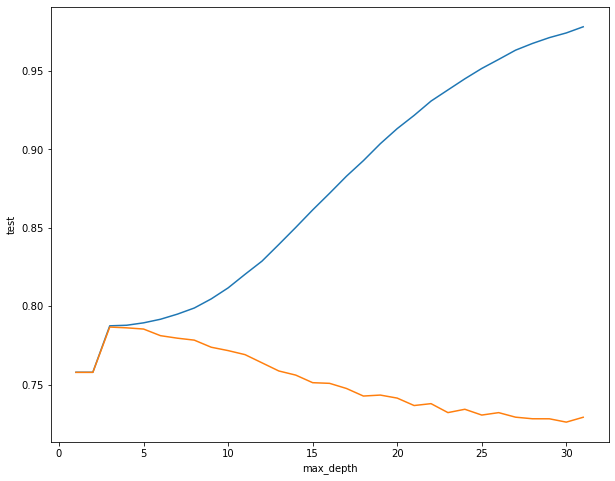

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.lineplot(x='max_depth', y='train', data=resultados)
sns.lineplot(x='max_depth', y='test', data=resultados);

# Busca de hiperparametros

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]
}

In [18]:
busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=GroupKFold(n_splits=10))
busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014543,0.000858,0.002469,0.000056,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.014246,0.000117,0.002464,0.000061,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.014202,0.000084,0.002402,0.000016,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.014152,0.000115,0.002432,0.000054,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.014218,0.000172,0.002415,0.000027,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [19]:
melhor = busca.best_estimator_

In [20]:
# Evitar essa abordagem pois está muito otimista
y_pred = melhor.predict(x_azar)
from sklearn.metrics import accuracy_score

In [21]:
accuracy_score(y_azar, y_pred)

0.7875

## Como ter uma estimativa sem esse vicio nos dados que eu já vi?

In [22]:
from sklearn.model_selection import cross_val_score

In [23]:
cross_val_score(busca, x_azar, y_azar, cv=GroupKFold(n_splits=10), groups=dados.modelo)

/home/phomint/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/phomint/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/phomint/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/home/phomint/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 736, in fit
    self._run_search(evaluate_candidates)
  File "/home/phomint/anaconda3/envs/datascience/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1188, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File 

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

## Infelizmente como o Pandas não suporta nested validation com group k fold não conseguimos prever o resultado para novos grupos

In [24]:
from sklearn.model_selection import KFold
busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=KFold(n_splits=5, shuffle=True))
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021187,0.010095,0.003323,0.000894,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.778,0.782,0.8045,0.792,0.7785,0.787,0.010095,1
1,0.012946,0.000069,0.002566,0.000055,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.778,0.782,0.8045,0.792,0.7785,0.787,0.010095,1
2,0.013344,0.000511,0.002640,0.000141,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.778,0.782,0.8045,0.792,0.7785,0.787,0.010095,1
3,0.012914,0.000075,0.002553,0.000039,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.778,0.782,0.8045,0.792,0.7785,0.787,0.010095,1
4,0.012904,0.000083,0.002513,0.000007,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.778,0.782,0.8045,0.792,0.7785,0.787,0.010095,1


In [25]:
melhor = busca.best_estimator_

In [26]:
cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))

array([0.7655, 0.8   , 0.787 , 0.791 , 0.791 ])

In [27]:
from sklearn.model_selection import RandomizedSearchCV

In [29]:
espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]
}
busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=KFold(n_splits=5, shuffle=True),
                           n_iter=16)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.022100,0.003926,0.003991,0.001084,32,64,3,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.7955,0.78,0.7840,0.7835,0.791,0.7868,0.005627,1
1,0.013028,0.000159,0.002647,0.000071,32,64,3,gini,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.7955,0.78,0.7840,0.7835,0.791,0.7868,0.005627,1
2,0.017762,0.000760,0.003008,0.000693,32,64,5,gini,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.7895,0.78,0.7805,0.7755,0.791,0.7833,0.005955,11
3,0.020472,0.000050,0.002563,0.000021,64,128,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7895,0.78,0.7840,0.7755,0.791,0.7840,0.005788,9
4,0.016784,0.000117,0.002587,0.000043,64,128,5,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7895,0.78,0.7800,0.7755,0.791,0.7832,0.006005,15


In [31]:
melhor = busca.best_estimator_
cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))

array([0.785 , 0.777 , 0.7845, 0.789 , 0.7935])

In [32]:
from scipy.stats import randint
espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 25, 30, None],
    "min_samples_split": randint(32,128),
    "min_samples_leaf": randint(32,128),
    "criterion": ["gini", "entropy"]
}
busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=KFold(n_splits=5, shuffle=True),
                           n_iter=16)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032083,0.005370,0.003496,0.001380,entropy,15,97,76,"{'criterion': 'entropy', 'max_depth': 15, 'min...",0.7725,0.7745,0.7730,0.7820,0.7865,0.7777,0.005573,13
1,0.013371,0.000598,0.002849,0.000404,gini,3,63,91,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7905,0.7780,0.7770,0.7875,0.8015,0.7869,0.008986,1
2,0.022555,0.000224,0.002693,0.000067,gini,15,101,34,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7810,0.7660,0.7695,0.7815,0.7850,0.7766,0.007439,14
3,0.039031,0.005024,0.003919,0.000942,entropy,30,85,54,"{'criterion': 'entropy', 'max_depth': 30, 'min...",0.7660,0.7755,0.7730,0.7845,0.7950,0.7788,0.010033,11
4,0.019902,0.001935,0.004074,0.000606,gini,3,117,65,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7905,0.7780,0.7770,0.7875,0.8015,0.7869,0.008986,1


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit

espaco_de_parametros = {
    "n_estimators" : randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split": randint(32,128),
    "min_samples_leaf": randint(32,128),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

busca = RandomizedSearchCV(RandomForestClassifier(), espaco_de_parametros,
                           cv=split,
                           n_iter=16)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.495760,0.0,0.029235,0.0,True,gini,3,46,85,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7745,0.0,6
1,0.381981,0.0,0.021964,0.0,True,entropy,4,69,125,67,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7750,0.7750,0.0,5
2,0.374800,0.0,0.021854,0.0,False,gini,3,49,68,72,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7675,0.7675,0.0,13
3,0.079651,0.0,0.007225,0.0,True,entropy,3,54,109,16,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7490,0.7490,0.0,15
4,0.590861,0.0,0.025322,0.0,False,entropy,5,35,61,72,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7765,0.7765,0.0,2
